In [1]:
import requests
import os

In [2]:
def download_file(url, filename):
    """
    Download a file from a given URL and save it to a given filename.
    If the file already exists, do nothing.
    """
    if not os.path.exists(filename):
        # send a GET request to the URL
        response = requests.get(url)
        # write the content of the response to a file
        with open(filename, 'wb') as file:
            file.write(response.content)

In [3]:
# Download the BERT vocabulary file if not already present
VOCAB_URL = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"
VOCAB_FILE = "bert-base-uncased-vocab.txt"

download_file(VOCAB_URL, VOCAB_FILE)

In [4]:
import nltk
from nltk.corpus import stopwords

In [5]:
# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import pickle

In [7]:
def save_to_pickle(obj, filename):
    """
    Save an object to a pickle file.
    """
    print(f"Saving {filename} to pickle file...")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def load_from_pickle(filename):
    """
    Load an object from a pickle file if it exists.
    """
    if not os.path.exists(filename):
        return None
    print(f"Loading {filename} from pickle file...")
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [8]:
import bz2
import pandas as pd; print(pd.__version__)
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re
import emoji

2.1.1


In [9]:
DetectorFactory.seed = 42

In [10]:
def preprocess_data(sample_size, filename):
    # Load and balance the dataset
    file_path = 'train.ft.txt.bz2'
    positive_reviews = []
    negative_reviews = []

    # we want to use a balanced dataset of sample reviews
    # we pick half negative and half positive reviews
    with bz2.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            label = int(label[-1])
            if label == 1 and len(negative_reviews) < sample_size // 2:
                negative_reviews.append([label, text])
            elif label == 2 and len(positive_reviews) < sample_size // 2:
                positive_reviews.append([label, text])
            if len(positive_reviews) == sample_size // 2 and len(negative_reviews) == sample_size // 2:
                break

    # Combine positive and negative reviews
    data = positive_reviews + negative_reviews
    df = pd.DataFrame(data, columns=['label', 'text'])

    # Function to detect language
    def detect_language(text):
        try:
            return detect(text)
        except LangDetectException:
            return "unknown"

    # Detect language
    df['language'] = df['text'].apply(detect_language)

    # Filter out non-English reviews
    df = df[df['language'] == 'en']
    df = df.drop(columns=['language'])

    # Initialize stopwords
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        # Replace emojis with descriptive words
        text = emoji.demojize(text, delimiters=(" ", " "))
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    # Apply text cleaning to the 'text' column
    df['text'] = df['text'].apply(clean_text)

    # this is a rather simple way to shuffle a DataFrame
    df = df.sample(frac=1,random_state=42)

    return df

In [11]:

SAMPLE_SIZE = 20_000

In [12]:
# %% Load and pre-process dataset, then save using pickle

# Define the path for the pickle file
PROCESSED_DATA_FILE = 'processed_data.pkl'

# Check if the processed data already exists
df = load_from_pickle(PROCESSED_DATA_FILE)

# If the processed data does not exist, preprocess the data
if df is None:
    df = preprocess_data(SAMPLE_SIZE, PROCESSED_DATA_FILE)
    save_to_pickle(df, PROCESSED_DATA_FILE)

# Show the first 5 rows of the processed dataset
print(df.head())

Loading processed_data.pkl from pickle file...
       label                                               text
4601       2  nice best wanted try moisturizer since love ex...
5535       2  confusing entertaining movie hard follow actio...
14912      1  sufficient long day computer writer work hours...
3478       2  fascinating started writing sci fi book actual...
12305      1  junk music stop listening music years ago expl...


In [13]:
import seaborn as sns

<Axes: xlabel='label', ylabel='count'>

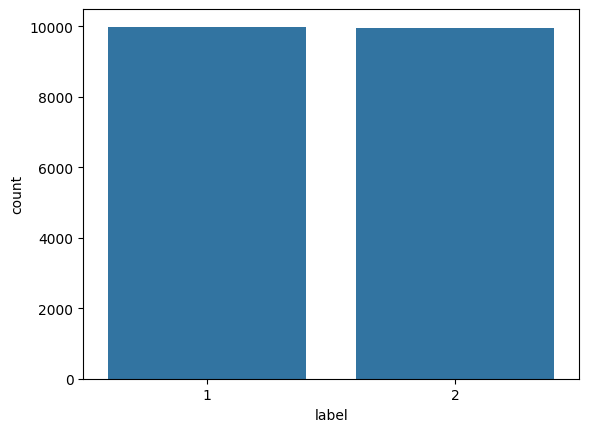

In [14]:
sns.countplot(x=df['label'])

In [15]:
import numpy as np; print(np.__version__)

1.26.1


In [16]:
#SLICE_SIZE = 5_000
#df_slice_1 = df[:SLICE_SIZE // 2].copy()
#df_slice_2 = df[df.shape[0] // 2: df.shape[0] // 2 + SLICE_SIZE // 2].copy()
#df_slice_2.index = np.arange(SLICE_SIZE // 2, SLICE_SIZE)
#df_slice = pd.concat([df_slice_1, df_slice_2])
df_slice = df # originally we did some tests with smaller DataFrame sizes. Now this cell is simply an alias for the same DataFrame

In [17]:
df_slice['label'] = df_slice['label'].apply(lambda l: int(l > 1))

<Axes: xlabel='label', ylabel='count'>

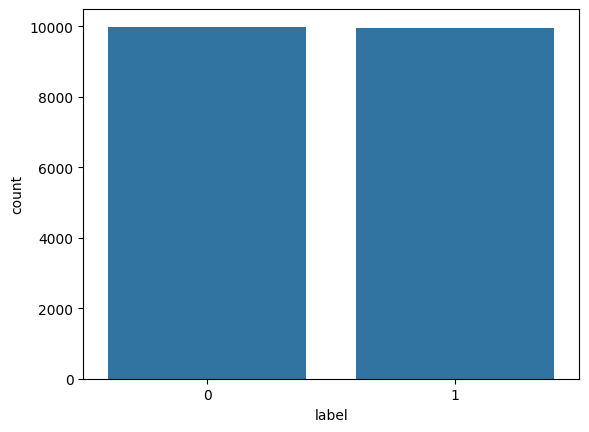

In [18]:
sns.countplot(x=df_slice['label'])

In [19]:
tokenized_reviews = df_slice['text'].apply(lambda x: x.split())

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer


In [21]:

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)


In [22]:
text_counts = cv.fit_transform(df_slice['text'])

C:\Users\dimig\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = text_counts
y = df_slice['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [26]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

MultinomialNB()

In [27]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

In [28]:
y_pred = MNB.predict(X_test)

In [29]:
print(f"Multinomial Naive Bayes (MNB) with ngram_range={cv.ngram_range}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

Multinomial Naive Bayes (MNB) with ngram_range=(1, 1)
Accuracy: 0.8385964912280702


              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1945
           1       0.85      0.83      0.84      2045

    accuracy                           0.84      3990
   macro avg       0.84      0.84      0.84      3990
weighted avg       0.84      0.84      0.84      3990



[[1641  304]
 [ 340 1705]]


In [30]:
# let's try different n-grams
cv = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)

In [31]:
text_counts = cv.fit_transform(df_slice['text'])

C:\Users\dimig\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
X_train, X_test, y_train, y_test = train_test_split(text_counts, y, test_size=0.2, random_state=42)

In [33]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)

print(f"Multinomial Naive Bayes (MNB) with ngram_range={cv.ngram_range}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))



Multinomial Naive Bayes (MNB) with ngram_range=(2, 2)
Accuracy: 0.8095238095238095


              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1945
           1       0.78      0.87      0.82      2045

    accuracy                           0.81      3990
   macro avg       0.81      0.81      0.81      3990
weighted avg       0.81      0.81      0.81      3990



[[1460  485]
 [ 275 1770]]


In [34]:
# let's try different n-grams
cv = CountVectorizer(stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)

In [35]:
text_counts = cv.fit_transform(df_slice['text'])

C:\Users\dimig\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
X_train, X_test, y_train, y_test = train_test_split(text_counts, y, test_size=0.2, random_state=42)

In [37]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)

print(f"Multinomial Naive Bayes (MNB) with ngram_range={cv.ngram_range}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))



Multinomial Naive Bayes (MNB) with ngram_range=(3, 3)
Accuracy: 0.6265664160401002


              precision    recall  f1-score   support

           0       0.78      0.32      0.46      1945
           1       0.59      0.92      0.72      2045

    accuracy                           0.63      3990
   macro avg       0.69      0.62      0.59      3990
weighted avg       0.68      0.63      0.59      3990



[[ 627 1318]
 [ 172 1873]]


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [39]:
tfidf = TfidfVectorizer()


In [40]:
text_tf = tfidf.fit_transform(df_slice['text'])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(text_tf, y, test_size=0.2, random_state=42)

In [42]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)

print(f"Multinomial Naive Bayes (MNB) with TfidfVectorizer")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))


Multinomial Naive Bayes (MNB) with TfidfVectorizer
Accuracy: 0.849874686716792


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1945
           1       0.87      0.83      0.85      2045

    accuracy                           0.85      3990
   macro avg       0.85      0.85      0.85      3990
weighted avg       0.85      0.85      0.85      3990



[[1696  249]
 [ 350 1695]]


In [43]:
# %% Load and pre-process dataset, then save using pickle

# Define the path for the pickle file
PROCESSED_DATA_FILE = 'processed_data.pkl'

# Check if the processed data already exists
df_embeddings = load_from_pickle(PROCESSED_DATA_FILE)

# If the processed data does not exist, preprocess the data
if df_embeddings is None:
    df_embeddings = preprocess_data(SAMPLE_SIZE, PROCESSED_DATA_FILE)
    save_to_pickle(df_embeddings, PROCESSED_DATA_FILE)

# Show the first 5 rows of the processed dataset
print(df_embeddings.head())

Loading processed_data.pkl from pickle file...
       label                                               text
4601       2  nice best wanted try moisturizer since love ex...
5535       2  confusing entertaining movie hard follow actio...
14912      1  sufficient long day computer writer work hours...
3478       2  fascinating started writing sci fi book actual...
12305      1  junk music stop listening music years ago expl...


In [44]:
X = []
for sentence in list(df_embeddings['text']):
    X.append(sentence)
# X just contains all the review texts (in Sentiment Analysis usually referred to as 'sentences')

<Axes: ylabel='count'>

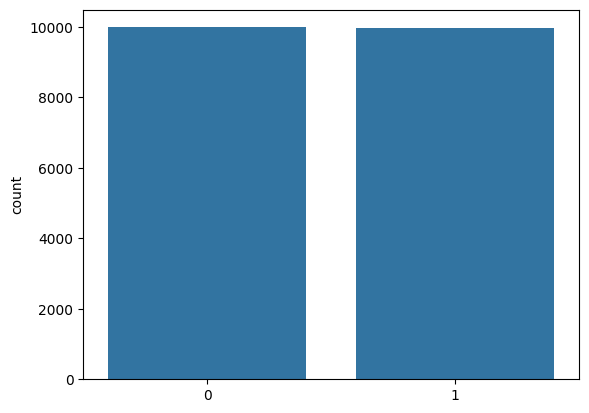

In [45]:
y = list(df_embeddings['label'])
y = np.array(list(map(lambda x: 1 if x == 2 or x == '2' else 0, y)))
# y is an array of labels. We want it to be an np.array type in order for the validation split to be possible in fitting the model

sns.countplot(x=y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# initial split

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# turn input sentences into sequences of tokens

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
vocab_size = len(tokenizer.word_index) + 1
# every key is another word in the vocabulary. The + 1 is because of reserving padding

max_length = 100

X_train = pad_sequences(X_train, padding = 'post', maxlen = max_length)
X_test = pad_sequences(X_test , padding = 'post', maxlen = max_length)


In [51]:
# requires embeddings to have already been computed by the LSTM code
EMBEDDINGS_MATRIX_FILE = 'embeddings_matrix.pkl'

embedding_matrix = load_from_pickle(EMBEDDINGS_MATRIX_FILE)

Loading embeddings_matrix.pkl from pickle file...


In [52]:
# turn X_train and X_test token sequences into embeddings

def to_embeddings(X, max_length, vocab_size, embedding_matrix):
    X_embeddings = np.zeros((len(X), max_length, 100))
    for i, sentence in enumerate(X):
        for j, token in enumerate(sentence):
            if token == 0:
                continue
            X_embeddings[i, j] = embedding_matrix[token]
    return X_embeddings


In [53]:
X_train = to_embeddings(X_train, max_length, vocab_size, embedding_matrix)
X_test = to_embeddings(X_test, max_length, vocab_size, embedding_matrix)
X_train.shape

(15960, 100, 100)

In [54]:

# flatten the embeddings
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(15960, 10000)

In [55]:
# normalize the embeddings with min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
# train a Naive Bayes classifier on the embeddings

from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

y_pred = MNB.predict(X_test)

print(f"Multinomial Naive Bayes (MNB) with embeddings")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\n")
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))



Multinomial Naive Bayes (MNB) with embeddings
Accuracy: 0.5959899749373434


              precision    recall  f1-score   support

           0       0.59      0.58      0.58      1945
           1       0.61      0.61      0.61      2045

    accuracy                           0.60      3990
   macro avg       0.60      0.60      0.60      3990
weighted avg       0.60      0.60      0.60      3990



[[1131  814]
 [ 798 1247]]
